<a href="https://colab.research.google.com/github/jacobgreen4477/The-4th-ETRI-AI-Human-Understanding-Competition/blob/main/ETRI_v1_0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> title : 제 4회 ETRI 휴먼이해 인공지능 논문경진대회 <br>
> author : hjy <br>

In our study, we used smartphones, smartwatches, sleep sensors, and self-recording apps to collect daily life logs and sleep health records of study participants in 2024.The data collection procedures and methods followed a similar approach to those used in previous studies. Here, we pu﻿blicly provide the following 12 data items, which comprise a total of 700 days' worth of lifelog data, strictly for non-commercial and academic research purposes only.
- mACStatus: Indicates whether the smartphone is currently being charged.
- mActivity: Value calculated by the Google Activity Recognition API.
- mAmbience: Ambient sound identification labels and their respective probabilities.
- mBle: Bluetooth devices around individual subject.
- mGps: Multiple GPS coordinates measured within a single minute using the smartphone.
- mLight: Ambient light measured by the smartphone.
- mScreenStatus: Indicates whether the smartphone screen is in use.
- mUsageStats: Indicates which apps were used on the smartphone and for how long.
- mWifi: Wifi devices around individual subject.
- wHr: Heart rate readings recorded by the smartwatch.
- wLight: Ambient light measured by the smartwatch.
- wPedo: Step data recorded by the smartwatch.

For the purpose of training a learning model to predict sleep health, fatigue, and stress, the following six metrics were derived from sleep sensor data and self-reported survey records. Each metric consists of values categorized into either two levels (0, 1) or three levels (0, 1, 2), depending on the specific metric. The detailed classification criteria for each metric's levels will be provided in a separate document.
- Q1: Overall sleep quality as perceived by a subject immediately after waking up.
- Q2: Physical fatigue of a subject just before sleep.
- Q3: Stress level experienced by a subject just before sleep.
- S1: Adherence to sleep guidelines for total sleep time (TST).
- S2: Adherence to sleep guidelines for sleep efficiency (SE).
- S3: Adherence to sleep guidelines for sleep onset latency (SOL, or SL).

### 📦 라이브러리

In [1]:
! pip install haversine
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from tqdm.auto import tqdm
from collections import Counter
from scipy.stats import entropy
from haversine import haversine  # 설치 필요: pip install haversine

warnings.filterwarnings('ignore')

In [5]:
import re
import ast
from tqdm import tqdm  # ← 추가
from math import radians, cos, sin, asin, sqrt
from datetime import time
from datetime import timedelta

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# pandas 옵션
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%0.4f' % x)

### 📦 데이터 읽기

In [ ]:
path = '/content/drive/MyDrive/data/ch2025_data_items/'

# 1
mACStatus = pd.read_parquet(path+'ch2025_mACStatus.parquet')
mActivity = pd.read_parquet(path+'ch2025_mActivity.parquet')
mAmbience = pd.read_parquet(path+'ch2025_mAmbience.parquet')
mBle = pd.read_parquet(path+'ch2025_mBle.parquet')
mGps = pd.read_parquet(path+'ch2025_mGps.parquet')
mLight = pd.read_parquet(path+'ch2025_mLight.parquet')
mScreenStatus = pd.read_parquet(path+'ch2025_mScreenStatus.parquet')
mUsageStats = pd.read_parquet(path+'ch2025_mUsageStats.parquet')
mWifi = pd.read_parquet(path+'ch2025_mWifi.parquet')
wHr = pd.read_parquet(path+'ch2025_wHr.parquet')
wLight = pd.read_parquet(path+'ch2025_wLight.parquet')
wPedo = pd.read_parquet(path+'ch2025_wPedo.parquet')

# 2
# train = pd.read_csv('/content/drive/MyDrive/data/ch2025_metrics_train.csv')
# test = pd.read_csv('/content/drive/MyDrive/data/ch2025_submission_sample.csv')
metrics_train = pd.read_csv('/content/drive/MyDrive/ETRI/ETRI_lifelog_dataset/ch2025_metrics_train.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/ETRI/ETRI_lifelog_dataset/ch2025_submission_sample.csv')

In [ ]:
# ✅ 기준 쌍 (subject_id, lifelog_date)
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date'])
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date))

# ✅ DataFrame 별 timestamp 컬럼 수동 지정
dataframes = {
    'mACStatus': (mACStatus_df, 'timestamp'),
    'mActivity': (mActivity_df, 'timestamp'),
    'mAmbience': (mAmbience_df, 'timestamp'),
    'mBle': (mBle_df, 'timestamp'),
    'mGps': (mGps_df, 'timestamp'),
    'mLight': (mLight_df, 'timestamp'),
    'mScreenStatus': (mScreenStatus_df, 'timestamp'),
    'mUsageStats': (mUsageStats_df, 'timestamp'),
    'mWifi': (mWifi_df, 'timestamp'),
    'wHr': (wHr_df, 'timestamp'),
    'wLight': (wLight_df, 'timestamp'),
    'wPedo': (wPedo_df, 'timestamp'),
}

# ✅ 분리 함수
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'):
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
    df = df.dropna(subset=[timestamp_col])
    df['date_only'] = df[timestamp_col].dt.date
    df['key'] = list(zip(df[subject_col], df['date_only']))

    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key'])
    return test_df, train_df

# ✅ 결과 저장
for name, (df, ts_col) in dataframes.items():
    print(f"⏳ {name} 분리 중...")
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col)
    globals()[f"{name}_test"] = test_df
    globals()[f"{name}_train"] = train_df
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}")

### ✅ mACStatus 핸드폰 충전상태
- Indicates whether the smartphone is currently being charged.
- m_charging : 0/1 상태
- 핸드폰이 오랫 동안 충전했다는 의미?
 - 한 자리에 장시간 머물러 있었다.
 - 핸드폰을 장시간 사용하지 않았다.  

In [234]:
mACStatus['lifelog_date'] = mACStatus['timestamp'].astype(str).str[:10]
mACStatus.head(1)

,subject_id,timestamp,m_charging,lifelog_date
0,id01,2024-06-26 12:03:00,0,2024-06-26


In [235]:
def process_mACStatus(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(['subject_id', 'timestamp'])

    results = []

    for (subj, lifelog_date), group in df.groupby(['subject_id', 'lifelog_date']):
        status = group['m_charging'].values  # 0/1 상태
        times = group['timestamp'].values

        ratio_charging = status.mean()
        sum_charging = status.sum()

        # 상태 전이 횟수
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1 상태 길이들
        lengths = []
        current_len = 0
        for val in status:
            if val == 1:
                current_len += 1
            elif current_len > 0:
                lengths.append(current_len)
                current_len = 0
        if current_len > 0:
            lengths.append(current_len)

        avg_charging_duration = np.mean(lengths) if lengths else 0
        max_charging_duration = np.max(lengths) if lengths else 0

        results.append({
            'subject_id': subj,
            'lifelog_date': lifelog_date,
            'charging_ratio': ratio_charging,
            'charging_sum': sum_charging,
            'charging_transitions': transitions,
            'avg_charging_duration': avg_charging_duration,
            'max_charging_duration': max_charging_duration,
        })

    return pd.DataFrame(results)

mACStatus2 = process_mACStatus(mACStatus)

# check
print(f'# mACStatus2 shape: {mACStatus2.shape}')
mACStatus2.head()

# mACStatus2 shape: (700, 7)


,subject_id,lifelog_date,charging_ratio,charging_sum,charging_transitions,avg_charging_duration,max_charging_duration
0,id01,2024-06-26,0.2159,147,22,13.3636,41
1,id01,2024-06-27,0.1586,222,32,13.8750,65
2,id01,2024-06-28,0.1803,256,29,17.0667,76
3,id01,2024-06-29,0.2866,384,3,192.0000,328
4,id01,2024-06-30,0.1443,202,8,50.5000,91


### ✅ mActivity 추정행동
- Value calculated by the Google Activity Recognition API.
 - 0 : IN_VEHICLE
 - 1 : ON_BICYCLE
 - 2 : ON_FOOT
 - 3 : STILL (not moving)
 - 8 : RUNNING
 - 3 : TILTING (This often occurs when a device is picked up from a desk or a user who is sitting stands up.)
 - 4 : UNKNOWN
 - 7 : WALKING

- 근무시간   : 오전 7시부터 오후 6시까지
- 근무외시간 : 오후6시부터 12시까지

In [236]:
mActivity['lifelog_date'] = mActivity['timestamp'].astype(str).str[:10]
mActivity.head(1)

,subject_id,timestamp,m_activity,lifelog_date
0,id01,2024-06-26 12:03:00,4,2024-06-26


In [237]:
def process_mActivity_by_timezones(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    def summarize(group_df, prefix=''):
        summary = []
        for (subj, date), group in group_df.groupby(['subject_id', 'lifelog_date']):
            counts = group['m_activity'].value_counts(normalize=True)
            counts2 = group['m_activity'].value_counts()
            row = {'subject_id': subj, 'lifelog_date': date}

            for i in range(9):
                row[f'{prefix}activity_{i}_ratio'] = counts.get(i, 0)
                row[f'{prefix}activity_{i}_count'] = counts2.get(i, 0)

            row[f'{prefix}dominant_activity'] = group['m_activity'].mode()[0] if not group['m_activity'].mode().empty else None
            row[f'{prefix}num_unique_activities'] = group['m_activity'].nunique()

            summary.append(row)
        return pd.DataFrame(summary)

    # 전체 데이터 요약 (prefix 없음)
    total_summary = summarize(df)

    # 근무시간 (07:00 ~ 18:00)
    worktime_df = df[(df['hour'] >= 7) & (df['hour'] < 18)]
    worktime_summary = summarize(worktime_df, prefix='worktime_')

    # 근무외시간 (18:00 ~ 24:00)
    afterwork_df = df[(df['hour'] >= 18) & (df['hour'] < 24)]
    afterwork_summary = summarize(afterwork_df, prefix='afterwork_')

    # 취침시간 (00:00 ~ 07:00)
    sleeptime_df = df[(df['hour'] >= 0) & (df['hour'] < 7)]
    sleeptime_summary = summarize(sleeptime_df, prefix='sleeptime_')

    # subject_id와 lifelog_date 기준으로 모두 합치기
    result = total_summary.copy()
    result = pd.merge(result, worktime_summary, on=['subject_id', 'lifelog_date'], how='left')
    result = pd.merge(result, afterwork_summary, on=['subject_id', 'lifelog_date'], how='left')
    result = pd.merge(result, sleeptime_summary, on=['subject_id', 'lifelog_date'], how='left')

    # 컬럼 정렬
    cols = ['subject_id', 'lifelog_date'] + [col for col in result.columns if col not in ['subject_id', 'lifelog_date']]
    result = result[cols]

    # 결측 처리
    result = result.fillna(0)

    return result

mActivity2 = process_mActivity_by_timezones(mActivity)

# check
print(f'# mActivity2 shape: {mActivity2.shape}')
mActivity2.head()

# mActivity2 shape: (700, 82)


,subject_id,lifelog_date,activity_0_ratio,activity_0_count,activity_1_ratio,activity_1_count,activity_2_ratio,activity_2_count,activity_3_ratio,activity_3_count,activity_4_ratio,activity_4_count,activity_5_ratio,activity_5_count,activity_6_ratio,activity_6_count,activity_7_ratio,activity_7_count,activity_8_ratio,activity_8_count,dominant_activity,num_unique_activities,worktime_activity_0_ratio,worktime_activity_0_count,worktime_activity_1_ratio,worktime_activity_1_count,worktime_activity_2_ratio,worktime_activity_2_count,worktime_activity_3_ratio,worktime_activity_3_count,worktime_activity_4_ratio,worktime_activity_4_count,worktime_activity_5_ratio,worktime_activity_5_count,worktime_activity_6_ratio,worktime_activity_6_count,worktime_activity_7_ratio,worktime_activity_7_count,worktime_activity_8_ratio,worktime_activity_8_count,worktime_dominant_activity,worktime_num_unique_activities,afterwork_activity_0_ratio,afterwork_activity_0_count,afterwork_activity_1_ratio,afterwork_activity_1_count,afterwork_activity_2_ratio,afterwork_activity_2_count,afterwork_activity_3_ratio,afterwork_activity_3_count,afterwork_activity_4_ratio,afterwork_activity_4_count,afterwork_activity_5_ratio,afterwork_activity_5_count,afterwork_activity_6_ratio,afterwork_activity_6_count,afterwork_activity_7_ratio,afterwork_activity_7_count,afterwork_activity_8_ratio,afterwork_activity_8_count,afterwork_dominant_activity,afterwork_num_unique_activities,sleeptime_activity_0_ratio,sleeptime_activity_0_count,sleeptime_activity_1_ratio,sleeptime_activity_1_count,sleeptime_activity_2_ratio,sleeptime_activity_2_count,sleeptime_activity_3_ratio,sleeptime_activity_3_count,sleeptime_activity_4_ratio,sleeptime_activity_4_count,sleeptime_activity_5_ratio,sleeptime_activity_5_count,sleeptime_activity_6_ratio,sleeptime_activity_6_count,sleeptime_activity_7_ratio,sleeptime_activity_7_count,sleeptime_activity_8_ratio,sleeptime_activity_8_count,sleeptime_dominant_activity,sleeptime_num_unique_activities
0,id01,2024-06-26,0.1252,89,0.0014,1,0,0,0.6723,478,0.1575,112,0,0,0,0,0.0436,31,0.0000,0,3,5,0.0700,25.0000,0.0028,1.0000,0.0000,0.0000,0.8768,313.0000,0.0028,1.0000,0.0000,0.0000,0.0000,0.0000,0.0476,17.0000,0.0000,0.0000,3.0000,5.0000,0.1808,64.0000,0.0000,0.0000,0.0000,0.0000,0.4661,165.0000,0.3136,111.0000,0.0000,0.0000,0.0000,0.0000,0.0395,14.0000,0.0000,0.0000,3.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,id01,2024-06-27,0.1465,211,0.0000,0,0,0,0.6111,880,0.2208,318,0,0,0,0,0.0215,31,0.0000,0,3,4,0.1030,68.0000,0.0000,0.0000,0.0000,0.0000,0.8712,575.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0258,17.0000,0.0000,0.0000,3.0000,3.0000,0.3222,116.0000,0.0000,0.0000,0.0000,0.0000,0.6528,235.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0250,9.0000,0.0000,0.0000,3.0000,3.0000,0.0643,27.0000,0.0000,0.0000,0.0000,0.0000,0.1667,70.0000,0.7571,318.0000,0.0000,0.0000,0.0000,0.0000,0.0119,5.0000,0.0000,0.0000,4.0000,4.0000
2,id01,2024-06-28,0.1118,161,0.0007,1,0,0,0.8618,1241,0.0007,1,0,0,0,0,0.0250,36,0.0000,0,3,5,0.1848,122.0000,0.0015,1.0000,0.0000,0.0000,0.7636,504.0000,0.0015,1.0000,0.0000,0.0000,0.0000,0.0000,0.0485,32.0000,0.0000,0.0000,3.0000,5.0000,0.0278,10.0000,0.0000,0.0000,0.0000,0.0000,0.9722,350.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,2.0000,0.0690,29.0000,0.0000,0.0000,0.0000,0.0000,0.9214,387.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0095,4.0000,0.0000,0.0000,3.0000,3.0000
3,id01,2024-06-29,0.0660,95,0.0000,0,0,0,0.9167,1320,0.0000,0,0,0,0,0,0.0174,25,0.0000,0,3,3,0.1242,82.0000,0.0000,0.0000,0.0000,0.0000,0.8424,556.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0333,22.0000,0.0000,0.0000,3.0000,3.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,360.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,1.0000,0.0310,13.0000,0.0000,0.0000,0.0000,0.0000,0.9619,404.00

### ✅ mAmbience 추정주변소리
- Ambient sound identification labels and their respective probabilities.
- 무슨 소리가 난게 중요할까?
- 새벽에 무슨 소리던지 소리가 난게 중요한 걸까?
- 여러 가지 소리 중에 노이즈도 포함되어 있을까?

In [40]:
def extract_labels_and_probs(row):
    items = row['m_ambience']
    labels = [item[0] for item in items]
    probs = [item[1] for item in items]
    return pd.Series({'labels': labels, 'prob': probs})

mAmbience[['labels', 'prob']]  = mAmbience.apply(extract_labels_and_probs, axis=1)
mAmbience['lifelog_date'] = mAmbience['timestamp'].astype(str).str[:10]
mAmbience = mAmbience.drop(columns=['m_ambience'])
mAmbience.head(1)

,subject_id,timestamp,labels,prob,lifelog_date
0,id01,2024-06-26 13:00:10,"[Music, Vehicle, Motor vehicle (road), Outside, urban or manmade, Outside, rural or natural, Car, Speech, Inside, large room or hall, Truck, Sound effect]","[0.30902618, 0.081680894, 0.04035286, 0.037144363, 0.032663062, 0.03199804, 0.029806137, 0.01684492, 0.016206821, 0.01591479]",2024-06-26


In [141]:
def process_mAmbience(df, top_n=3, special_labels=None):
    df = df.copy()

    # 시간 파생변수
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df['weekday'] = df['timestamp'].dt.weekday
    df['is_weekend'] = df['weekday'] >= 5

    def map_time_period(row):
        if 0 <= row['hour'] < 7:
            return 'sleeptime'
        elif 7 <= row['hour'] < 18:
            return 'worktime'
        else:
            return 'afterwork'

    df['time_period'] = df.apply(map_time_period, axis=1)

    # 타임스탬프 차이(초단위)
    df = df.sort_values(['subject_id', 'timestamp'])
    df['duration_sec'] = df.groupby(['subject_id'])['timestamp'].diff().dt.total_seconds()
    df['duration_sec'] = df['duration_sec'].fillna(0)

    def process_group(group):
        result = {}

        time_period = group['time_period'].iloc[0]  # 그룹별 time_period 가져오기

        labels = group['labels'].tolist()
        probs = group['prob'].tolist()
        durations = group['duration_sec'].tolist()

        flat_labels = [label for labels_list in labels for label in labels_list]
        flat_probs = [float(prob) for probs_list in probs for prob in probs_list]
        repeated_durations = [dur for labels_list, dur in zip(labels, durations) for _ in labels_list]

        if not flat_labels or not flat_probs:
            return pd.Series()

        flat_probs = np.array(flat_probs)

        # prefix 설정
        prefix = f'{time_period}_'

        result[prefix + 'max_label'] = flat_labels[np.argmax(flat_probs)]
        result[prefix + 'max_prob'] = np.max(flat_probs)
        result[prefix + 'entropy'] = entropy(flat_probs, base=2)
        result[prefix + 'label_count'] = len(flat_labels)

        # 정규식
        vehicle_pattern = re.compile(r'car|vehicle|truck|bus|motorcycle|bicycle|boat|ship|train|subway|aircraft|helicopter|engine', re.IGNORECASE)
        environment_pattern = re.compile(r'outside|inside|environment|ocean|rain|waterfall|wind|fire|waves|rustling|earthquake|explosion|thunder|smoke', re.IGNORECASE)
        human_pattern = re.compile(r'speech|baby|child|laughter|crying|shout|screaming|groan|cough|hubbub|snoring|whimper|talking|singing|giggle|chatter|babbling', re.IGNORECASE)
        music_pattern = re.compile(r'music|song|singing|choir|instrument|guitar|piano|violin|vocal|jazz|hip hop|pop|rock|opera|blues|folk|electronic|dubstep|reggae|house|metal|disco|dance|flamenco|trance|techno|saxophone|synthesizer|harp|accordion|clarinet|flute|drum|tabla|tambourine|maraca|steelpan|xylophone|orchestra|band', re.IGNORECASE)

        # 분류
        vehicle_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if vehicle_pattern.search(label)]
        environment_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if environment_pattern.search(label)]
        human_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if human_pattern.search(label)]
        music_related = [(label, dur) for label, dur in zip(flat_labels, repeated_durations) if music_pattern.search(label)]

        # has (존재 여부)
        result[prefix + 'has_vehicle_related'] = int(len(vehicle_related) > 0)
        result[prefix + 'has_environment_related'] = int(len(environment_related) > 0)
        result[prefix + 'has_human_related'] = int(len(human_related) > 0)
        result[prefix + 'has_music_related'] = int(len(music_related) > 0)

        # sum (개수)
        result[prefix + 'sum_vehicle_related'] = len(vehicle_related)
        result[prefix + 'sum_environment_related'] = len(environment_related)
        result[prefix + 'sum_human_related'] = len(human_related)

        return pd.Series(result)

    features = df.groupby(['subject_id', 'lifelog_date', 'time_period']).apply(process_group).reset_index()
    features = features.pivot(index=['subject_id', 'lifelog_date'], columns='level_3', values=0).reset_index()

    return features

In [142]:
mAmbience2 = process_mAmbience(mAmbience)

# check
print(f'# mAmbience2 shape: {mAmbience2.shape}')
mAmbience2.head()

# ch2025_mAmbience2 shape: (700, 35)


level_3,subject_id,lifelog_date,afterwork_entropy,afterwork_has_environment_related,afterwork_has_human_related,afterwork_has_music_related,afterwork_has_vehicle_related,afterwork_label_count,afterwork_max_label,afterwork_max_prob,afterwork_sum_environment_related,afterwork_sum_human_related,afterwork_sum_vehicle_related,sleeptime_entropy,sleeptime_has_environment_related,sleeptime_has_human_related,sleeptime_has_music_related,sleeptime_has_vehicle_related,sleeptime_label_count,sleeptime_max_label,sleeptime_max_prob,sleeptime_sum_environment_related,sleeptime_sum_human_related,sleeptime_sum_vehicle_related,worktime_entropy,worktime_has_environment_related,worktime_has_human_related,worktime_has_music_related,worktime_has_vehicle_related,worktime_label_count,worktime_max_label,worktime_max_prob,worktime_sum_environment_related,worktime_sum_human_related,worktime_sum_vehicle_related
0,id01,2024-06-26,9.2578,1,1,1,1,1540,Silence,1.0000,258,244,333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.1810,1,1,1,1,1500,Silence,1.0000,415,135,270
1,id01,2024-06-27,7.4919,1,1,1,0,1800,Silence,1.0000,180,900,0,7.7287,1,1,1,1,2100,Silence,1.0000,211,1045,6,8.3663,1,1,1,0,3300,Silence,1.0000,330,1650,0
2,id01,2024-06-28,7.4933,1,1,1,0,1800,Silence,1.0000,183,898,0,7.7476,1,1,1,1,2100,Silence,1.0000,214,1041,6,8.3219,1,1,1,0,3200,Silence,1.0000,320,1600,0
3,id01,2024-06-29,7.4919,1,1,1,0,1800,Silence,1.0000,180,900,0,7.7142,1,1,1,0,2100,Silence,1.0000,210,1050,0,8.3812,1,1,1,0,3300,Silence,1.0000,330,1645,0
4,id01,2024-06-30,7.5039,1,1,1,1,1800,Silence,1.0000,184,895,1,7.7142,1,1,1,0,2100,Silence,1.0000,210,1050,0,8.3663,1,1,1,0,3300,Silence,1.0000,330,1650,0


### ✅ mBle 블루투스
- Bluetooth devices around individual subject.
 - 7936 : Wearable, Headset, AV Device
 - 1796 : Peripheral (입력장치) 계열
 - 0 : 정보 없음 또는 알 수 없음(Unknown)
 - 1084 : Audio/Video (스피커, 헤드셋, 이어폰, TV 등)
 - 524 : Phone (휴대폰, 스마트폰)
 - 1060 : Headphones
 - 284 : commputer (PC, 노트북, PDA)

In [157]:
def extract_mble_info(row):
    m_data = row['m_ble']
    address = [item['address'] for item in m_data]
    device_class = [item['device_class'] for item in m_data]
    rssi = [item['rssi'] for item in m_data]
    return pd.Series({'address': address, 'device_class': device_class, 'rssi': rssi})

mBle[['address','device_class','rssi']] = mBle.apply(extract_mble_info, axis=1)
mBle['lifelog_date'] = mBle['timestamp'].astype(str).str[:10]
mBle.head(1)

,subject_id,timestamp,m_ble,address,device_class,rssi,lifelog_date
0,id01,2024-06-26 12:13:00,"[{'address': '00:15:7C:11:80:8D', 'device_class': '0', 'rssi': -82}, {'address': '01:B1:D2:20:9E:3A', 'device_class': '0', 'rssi': -61}, {'address': '04:33:1F:D9:C1:50', 'device_class': '0', 'rssi': -86}, {'address': '06:5C:2D:BC:39:BE', 'device_class': '0', 'rssi': -75}, {'address': '09:42:21:0D:AD:DF', 'device_class': '0', 'rssi': -70}, {'address': '0B:66:0D:D5:9C:4A', 'device_class': '0', 'rssi': -89}, {'address': '10:B5:88:E7:85:69', 'device_class': '0', 'rssi': -89}, {'address': '13:F0:CA:3B:DB:EF', 'device_class': '0', 'rssi': -77}, {'address': '1A:23:C0:8F:43:4D', 'device_class': '0', 'rssi': -66}, {'address': '24:11:53:BB:62:89', 'device_class': '1796', 'rssi': -37}, {'address': '24:2D:F0:EE:1E:D0', 'device_class': '0', 'rssi': -85}, {'address': '26:0C:48:28:15:77', 'device_class': '0', 'rssi': -63}, {'address': '27:C1:C0:8B:82:C9', 'device_class': '0', 'rssi': -88}, {'address': '28:9C:11:73:39:05', 'device_class': '0', 'rssi': -30}, {'address': '34:40:DE:35:F8:65', 'device_class': '0', 'rssi': -93}, {'address': '35:0A:59:BF:75:F5', 'device_class': '0', 'rssi': -72}, {'address': '41:A6:C4:20:E3:2C', 'device_class': '7936', 'rssi': -83}, {'address': '42:6B:51:95:1B:D4', 'device_class': '0', 'rssi': -77}, {'address': '44:B2:0B:78:04:0F', 'device_class': '0', 'rssi': -69}, {'address': '45:37:48:E2:7F:CC', 'device_class': '0', 'rssi': -87}, {'address': '4E:1B:C2:DF:C5:87', 'device_class': '0', 'rssi': -76}, {'address': '4E:9F:1B:A9:56:5D', 'device_class': '0', 'rssi': -66}, {'address': '50:63:B0:82:07:00', 'device_class': '0', 'rssi': -86}, {'address': '53:13:6C:4F:04:D2', 'device_class': '0', 'rssi': -69}, {'address': '54:15:89:95:27:44', 'device_class': '7936', 'rssi': -71}, {'address': '56:0E:2E:B0:D4:11', 'device_class': '0', 'rssi': -61}, {'address': '5A:7A:2E:42:03:B1', 'device_class': '0', 'rssi': -82}, {'address': '5A:9D:3E:AB:38:C6', 'device_class': '0', 'rssi': -83}, {'address': '5E:A6:8E:B8:74:74', 'device_class': '0', 'rssi': -84}, {'address': '5F:BC:08:0F:C1:6A', 'device_class': '0', 'rssi': -87}, {'address': '62:E1:9D:41:F4:AE', 'device_class': '0', 'rssi': -73}, {'address': '67:23:FE:88:69:A8', 'device_class': '0', 'rssi': -88}, {'address': '68:EC:C5:0C:D1:C1', 'device_class': '0', 'rssi': -78}, {'address': '6B:28:DA:C0:1B:29', 'device_class': '0', 'rssi': -75}, {'address': '6F:0B:91:00:33:19', 'device_class': '0', 'rssi': -80}, {'address': '70:7A:4B:82:44:90', 'device_class': '0', 'rssi': -88}, {'address': '7B:62:D4:5B:59:D3', 'device_class': '0', 'rssi': -74}, {'address': '7B:BE:A4:9D:FD:11', 'device_class': '0', 'rssi': -72}, {'address': '7F:FD:C4:00:77:7D', 'device_class': '0', 'rssi': -52}, {'address': 'C4:F0:92:C8:F1:8D', 'device_class': '7936', 'rssi': -87}, {'address': 'C7:3F:2C:7B:86:66', 'device_class': '7936', 'rssi': -89}]","[00:15:7C:11:80:8D, 01:B1:D2:20:9E:3A, 04:33:1F:D9:C1:50, 06:5C:2D:BC:39:BE, 09:42:21:0D:AD:DF, 0B:66:0D:D5:9C:4A, 10:B5:88:E7:85:69, 13:F0:CA:3B:DB:EF, 1A:23:C0:8F:43:4D, 24:11:53:BB:62:89, 24:2D:F0:EE:1E:D0, 26:0C:48:28:15:77, 27:C1:C0:8B:82:C9, 28:9C:11:73:39:05, 34:40:DE:35:F8:65, 35:0A:59:BF:75:F5, 41:A6:C4:20:E3:2C, 42:6B:51:95:1B:D4, 44:B2:0B:78:04:0F, 45:37:48:E2:7F:CC, 4E:1B:C2:DF:C5:87, 4E:9F:1B:A9:56:5D, 50:63:B0:82:07:00, 53:13:6C:4F:04:D2, 54:15:89:95:27:44, 56:0E:2E:B0:D4:11, 5A:7A:2E:42:03:B1, 5A:9D:3E:AB:38:C6, 5E:A6:8E:B8:74:74, 5F:BC:08:0F:C1:6A, 62:E1:9D:41:F4:AE, 67:23:FE:88:69:A8, 68:EC:C5:0C:D1:C1, 6B:28:DA:C0:1B:29, 6F:0B:91:00:33:19, 70:7A:4B:82:44:90, 7B:62:D4:5B:59:D3, 7B:BE:A4:9D:FD:11, 7F:FD:C4:00:77:7D, C4:F0:92:C8:F1:8D, C7:3F:2C:7B:86:66]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1796, 0, 0, 0, 0, 0, 0, 7936, 0, 0, 0, 0, 0, 0, 0, 7936, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7936, 7936]","[-82, -61, -86, -75, -70, -89, -89, -77, -66, -37, -85, -63, -88, -30, -93, -72, -83, -77, -69, -87, -76, -66, -86, -69, -71, -61, -82, -83, -84, -87, -73, -88, -78, -75, -80, 

In [173]:
def process_mBle(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 시간대 분류
    def map_time_period(row):
        if 0 <= row['hour'] < 7:
            return 'sleeptime'
        elif 7 <= row['hour'] < 18:
            return 'worktime'
        else:
            return 'afterwork'

    df['time_period'] = df.apply(map_time_period, axis=1)

    features = []

    for idx, row in df.iterrows():
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble']

        rssi_list = []
        class_0_cnt = 0
        class_other_cnt = 0

        for device in entry:
            try:
                rssi = int(device['rssi'])
                rssi_list.append(rssi)

                device_class = str(device['device_class'])
                if device_class == '0':
                    class_0_cnt += 1
                else:
                    class_other_cnt += 1
            except:
                continue  # malformed record

        feature = {
            'subject_id': row['subject_id'],
            'lifelog_date': row['lifelog_date'],
            'time_period': row['time_period'],
            'device_class_0_cnt': class_0_cnt,
            'device_class_others_cnt': class_other_cnt,
            'device_count': len(rssi_list),
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan,
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan,
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan,
        }
        features.append(feature)

    return pd.DataFrame(features)

def summarize_mBle_daily(df):

    # row 단위 BLE feature 추출
    df = process_mBle(df)

    # 하루 + 시간대별로 groupby
    grouped = df.groupby(['subject_id', 'lifelog_date', 'time_period']).agg({
        'device_class_0_cnt': 'sum',
        'device_class_others_cnt': 'sum',
        'rssi_mean': 'mean',
        'rssi_min': 'min',
        'rssi_max': 'max',
    }).reset_index()

    # 총합 구해서 비율 계산
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan)
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan)

    # 필요 없는 cnt 컬럼 제거
    grouped.drop(columns=[
        'device_class_0_cnt',
        'device_class_others_cnt'
    ], inplace=True)

    # pivot해서 time_period별로 펼치기
    final = grouped.pivot(index=['subject_id', 'lifelog_date'], columns='time_period')
    final.columns = ['_'.join(col).strip() for col in final.columns.values]
    final = final.reset_index()

    return final

In [174]:
mBl2 = summarize_mBle_daily(mBle)

# check
print(f'\n # mBl2 shape: {mBl2.shape}')
mBl2.head()

# ch2025_mBl2 shape: (651, 17)


,subject_id,lifelog_date,rssi_mean_afterwork,rssi_mean_sleeptime,rssi_mean_worktime,rssi_min_afterwork,rssi_min_sleeptime,rssi_min_worktime,rssi_max_afterwork,rssi_max_sleeptime,rssi_max_worktime,device_class_0_ratio_afterwork,device_class_0_ratio_sleeptime,device_class_0_ratio_worktime,device_class_others_ratio_afterwork,device_class_others_ratio_sleeptime,device_class_others_ratio_worktime
0,id01,2024-06-26,-76.2155,NaN,-75.0522,-92.0000,NaN,-94.0000,-43.0000,NaN,-27.0000,0.9237,NaN,0.9421,0.0763,NaN,0.0579
1,id01,2024-06-27,-71.3198,-75.4567,-74.7020,-94.0000,-89.0000,-93.0000,-34.0000,-55.0000,-46.0000,0.8482,0.7826,0.9457,0.1518,0.2174,0.0543
2,id01,2024-06-28,-76.6775,-74.1250,-77.2920,-94.0000,-91.0000,-92.0000,-45.0000,-60.0000,-39.0000,0.6491,0.6250,0.9580,0.3509,0.3750,0.0420
3,id01,2024-06-29,-74.7198,-61.6667,-66.8632,-92.0000,-89.0000,-93.0000,-40.0000,-33.0000,-38.0000,0.8519,0.7000,0.7740,0.1481,0.3000,0.2260
4,id01,2024-06-30,-69.9323,-72.0000,-77.2568,-92.0000,-72.0000,-92.0000,-35.0000,-72.0000,-40.0000,0.6538,1.0000,0.9231,0.3462,0.0000,0.0769


### ✅ mGps, GPS 기반 핸드폰 위치
- Multiple GPS coordinates measured within a single minute using the smartphone.
- speed가 1보다 큰경우 정지 상태가 아니고 움직이고 있다고 판단
 - 0.5-2 : 걸어서 이동하는 경우  
 - 2-5 : 조깅
 - 5 이상 : 차를 타고 이동하는 경우

- speed가 0.5-2사이를 하루에 몇분동안 지속했는지?
- speed가 2-5사이를 하루에 몇분동안 지속했는지? (유산소 운동 시간)
- speed가 5이상을 하루에 몇분동안 지속했는지?  

In [10]:
def extract_gps_info(row):
    m_data = row['m_gps']
    altitude = [item['altitude'] for item in m_data]
    latitude = [item['latitude'] for item in m_data]
    longitude = [item['longitude'] for item in m_data]
    speed = [item['speed'] for item in m_data]
    return pd.Series({'altitude': altitude, 'latitude': latitude, 'longitude': longitude, 'speed': speed})

mGps[['altitude','latitude','longitude','speed']] = mGps.apply(extract_gps_info, axis=1)
mGps['lifelog_date'] = mGps['timestamp'].astype(str).str[:10]
mGps = mGps.drop(columns=['m_gps'])
mGps.head(1)

,subject_id,timestamp,altitude,latitude,longitude,speed,lifelog_date
0,id01,2024-06-26 12:03:00,"[110.6, 110.8, 110.8, 110.7, 110.7, 110.8, 110.8, 110.8, 110.8, 110.8, 110.8]","[0.2077385, 0.2077759, 0.2077728, 0.20779, 0.2077914, 0.2077972, 0.2078002, 0.2077985, 0.207801, 0.207802, 0.2078011]","[0.170027, 0.1699851, 0.1699834, 0.1699686, 0.1699708, 0.1699657, 0.1699627, 0.1699631, 0.1699642, 0.1699639, 0.169963]","[0.0, 0.721, 0.0505, 0.6587, 0.0568, 0.1768, 0.0907, 0.0337, 0.0411, 0.0296, 0.0194]",2024-06-26


In [55]:
# 거리 계산 함수
def haversine(coord1, coord2, unit='m'):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371000  # 지구 반지름(m)
    return c * r if unit == 'm' else c * r / 1000

def process_mGps(df):
    df = df.copy()

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['week'] = df['timestamp'].dt.isocalendar().week

    expanded_rows = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing GPS data"):
        speeds = ast.literal_eval(row['speed']) if isinstance(row['speed'], str) else row['speed']
        lats = ast.literal_eval(row['latitude']) if isinstance(row['latitude'], str) else row['latitude']
        lons = ast.literal_eval(row['longitude']) if isinstance(row['longitude'], str) else row['longitude']
        alts = ast.literal_eval(row['altitude']) if isinstance(row['altitude'], str) else row['altitude']
        n = len(speeds)
        if n > 0:
            expanded_rows.append(pd.DataFrame({
                'subject_id': [row['subject_id']] * n,
                'lifelog_date': [row['lifelog_date']] * n,
                'timestamp': pd.date_range(start=row['timestamp'], periods=n, freq='1S'),
                'speed': speeds,
                'latitude': lats,
                'longitude': lons,
                'altitude': alts
            }))

    expanded_df = pd.concat(expanded_rows, ignore_index=True)

    # 벡터화
    speeds = expanded_df['speed'].values

    walk_mask = (0.5 <= speeds) & (speeds < 2)
    jog_mask = (2 <= speeds) & (speeds < 5)
    vehicle_mask = (speeds >= 5)
    le5_mask = (speeds <= 5)

    expanded_df['walk'] = walk_mask.astype(int)
    expanded_df['jog'] = jog_mask.astype(int)
    expanded_df['vehicle'] = vehicle_mask.astype(int)
    expanded_df['le5_speed'] = expanded_df['speed'].where(le5_mask)

    # 아침/저녁 구간 조건
    expanded_df['hour'] = expanded_df['timestamp'].dt.hour
    morning_condition = (expanded_df['hour'] >= 6) & (expanded_df['hour'] < 9) & (expanded_df['speed'] >= 1)
    evening_condition = (expanded_df['hour'] >= 21) & (expanded_df['hour'] <= 23) & (expanded_df['speed'] <= 1)

    # 이동 특성 계산
    movement_features = []
    for (subject_id, lifelog_date), group in expanded_df.groupby(['subject_id', 'lifelog_date']):
        all_speeds = group['speed'].values
        all_alts = group['altitude'].values
        all_lats = group['latitude'].values
        all_lons = group['longitude'].values

        active_mins = group.shape[0] / 60  # 1초 단위 → 분
        movement_ratio = (all_speeds > 1.0).mean() if len(all_speeds) > 0 else 0
        alt_change = all_alts[-1] - all_alts[0] if len(all_alts) > 0 else 0
        lat_change = all_lats[-1] - all_lats[0] if len(all_lats) > 0 else 0
        lon_change = all_lons[-1] - all_lons[0] if len(all_lons) > 0 else 0

        total_dist = 0.0
        if len(all_lats) > 1:
            for i in range(len(all_lats)-1):
                coord1 = (all_lats[i], all_lons[i])
                coord2 = (all_lats[i+1], all_lons[i+1])
                total_dist += haversine(coord1, coord2, unit='m')

        movement_features.append({
            'subject_id': subject_id,
            'lifelog_date': lifelog_date,
            'active_minutes': active_mins,
            'movement_ratio': movement_ratio,
            'alt_change': alt_change,
            'lat_change': lat_change,
            'lon_change': lon_change,
            'total_distance_m': total_dist
        })

    movement_df = pd.DataFrame(movement_features)

    # Groupby + Aggregation
    agg_funcs = {
        'walk_minutes': ('walk', lambda x: x.sum() / 60),
        'jog_minutes': ('jog', lambda x: x.sum() / 60),
        'vehicle_minutes': ('vehicle', lambda x: x.sum() / 60),
        'speed_le5_max': ('le5_speed', 'max'),
        'speed_le5_mean': ('le5_speed', 'mean'),
        'speed_le5_std': ('le5_speed', 'std')
    }

    grouped = expanded_df.groupby(['subject_id', 'lifelog_date']).agg(**agg_funcs).reset_index()
    grouped['exercise_flag'] = (grouped['jog_minutes'] >= 5)

    # 아침 wakeup time
    morning_first_movement = (
        expanded_df[morning_condition]
        .groupby(['subject_id', 'lifelog_date'])['timestamp']
        .min()
        .reset_index()
        .rename(columns={'timestamp': 'morning_wakeup_time'})
    )


    # 최종 merge
    final = pd.merge(grouped, movement_df, on=['subject_id', 'lifelog_date'], how='left')
    final = pd.merge(final, morning_first_movement, on=['subject_id', 'lifelog_date'], how='left')

    # 아침 wakeup_time 처리
    valid_wakeup = final['morning_wakeup_time'].dropna()
    if not valid_wakeup.empty:
        total_seconds = valid_wakeup.dt.hour * 3600 + valid_wakeup.dt.minute * 60 + valid_wakeup.dt.second
        mean_seconds = total_seconds.mean()
        mean_hour = int(mean_seconds // 3600)
        mean_minute = int((mean_seconds % 3600) // 60)
        mean_second = int(mean_seconds % 60)
        mean_wakeup_time = time(mean_hour, mean_minute, mean_second)
    else:
        mean_wakeup_time = time(7, 0, 0)

    final['morning_wakeup_time'] = final['morning_wakeup_time'].fillna(
        pd.Timestamp.combine(pd.to_datetime('today').date(), mean_wakeup_time)
    )
    final['morning_wakeup_time'] = final['morning_wakeup_time'].dt.hour * 100 + final['morning_wakeup_time'].dt.minute

    mean_wakeup_hhmm = mean_wakeup_time.hour * 100 + mean_wakeup_time.minute

    # wake_up_early_minutes
    def compute_minutes_diff(actual_hhmm, mean_hhmm):
        actual_hour = actual_hhmm // 100
        actual_minute = actual_hhmm % 100
        mean_hour = mean_hhmm // 100
        mean_minute = mean_hhmm % 100
        actual_sec = actual_hour * 3600 + actual_minute * 60
        mean_sec = mean_hour * 3600 + mean_minute * 60
        return (mean_sec - actual_sec) / 60

    final['wake_up_early_minutes'] = final['morning_wakeup_time'].apply(lambda x: compute_minutes_diff(x, mean_wakeup_hhmm))

    return final

In [56]:
%%time

mGps2 = process_mGps(mGps)

# check
print(f'\n # mGps2 shape: {mGps2.shape}')
mGps2.head()

Processing GPS data: 100%|██████████| 10000/10000 [00:07<00:00, 1292.48it/s]


# ch2025_mGps2 shape: (8, 17)


,subject_id,lifelog_date,walk_minutes,jog_minutes,vehicle_minutes,speed_le5_max,speed_le5_mean,speed_le5_std,exercise_flag,active_minutes,movement_ratio,alt_change,lat_change,lon_change,total_distance_m,morning_wakeup_time,wake_up_early_minutes
0,id01,2024-06-26,11.1667,1.3000,3.8667,4.9907,0.2503,0.5089,False,100.2833,0.1034,-6.7000,0.0229,-0.0757,29113.5760,610,0.0000
1,id01,2024-06-27,24.1833,5.0833,13.0500,4.9803,0.3126,0.6236,True,197.9000,0.1401,0.0000,0.0000,0.0001,93470.7971,601,9.0000
2,id01,2024-06-28,16.3500,3.8500,9.8000,4.9617,0.2453,0.5721,False,193.7167,0.1105,0.0000,0.0000,0.0000,68631.9831,632,-22.0000
3,id01,2024-06-29,25.8667,2.7167,4.6500,4.9630,0.2801,0.4821,False,192.3833,0.0865,0.6000,0.0000,0.0000,47104.5614,601,9.0000
4,id01,2024-06-30,13.7833,1.9500,4.6833,4.9995,0.1494,0.3887,False,210.1167,0.0494,-0.3000,-0.0000,-0.0000,41159.4568,600,10.0000


### ✅ mLight 주변 밝기
- Ambient light measured by the smartphone.
 - 어두운 밤	0.1 ~ 1 lux	캄캄한 방, 달빛 없는 밤
 - 가로등 켜진 거리	10 ~ 20 lux	흐릿한 외부 조명
 - 실내 조명	100 ~ 500 lux	사무실, 일반 거실
 - 밝은 실외	10,000 ~ 25,000 lux	맑은 날 햇빛
 - 직사광선 아래	30,000 ~ 100,000 lux	여름 한낮, 매우 강한 햇빛

- 밝기에 따라서 언제 불을 끄고 잠든 시간 추정
- 직사광선 잠에 좋은 영향을 주는지? (논문)
- 결측치 처리 x

In [28]:
mLight['lifelog_date'] = mLight['timestamp'].astype(str).str[:10]
mLight.head(2)

,subject_id,timestamp,m_light,lifelog_date
0,id01,2024-06-26 12:03:00,534.0000,2024-06-26
1,id01,2024-06-26 12:13:00,846.0000,2024-06-26


<Axes: >

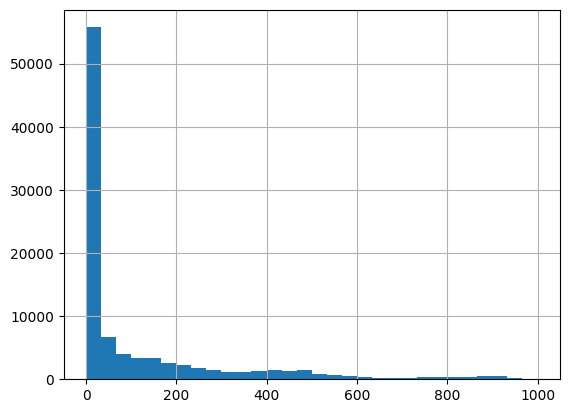

In [13]:
mLight.loc[mLight['m_light']<1000,'m_light'].hist(bins=30)

In [125]:
def process_mLight(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6)

    daily_light = df.groupby(['subject_id', 'lifelog_date']).agg(
        light_mean=('m_light', 'mean'),
        light_std=('m_light', 'std'),
        light_max=('m_light', 'max'),
        light_min=('m_light', 'min'),
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()),
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()),
        light_night_ratio=('is_night', 'mean')
    ).reset_index()

    results = []

    for subject_id, group in tqdm(df.groupby('subject_id'), desc="Processing sleep detection"):
        group = group.sort_values('timestamp').reset_index(drop=True)

        sleep_time = None
        wake_time = None
        sleeping = False
        zero_count = 0
        first_zero_time = None

        for i in range(len(group)):
            light = group.loc[i, 'm_light']
            hour = group.loc[i, 'hour']

            if light == 0:
                zero_count += 1
                if zero_count == 1:
                    first_zero_time = group.loc[i, 'timestamp']
                if zero_count == 6 and not sleeping:
                    sleep_hour = first_zero_time.hour
                    if (sleep_hour >= 21) or (sleep_hour <= 2):
                        sleep_time = first_zero_time
                        sleeping = True
            else:
                if sleeping:
                    candidate_wakeup = group.loc[i, 'timestamp']
                    wake_hour = candidate_wakeup.hour
                    if 5 <= wake_hour <= 9:
                        wake_time = candidate_wakeup
                        results.append({
                            'subject_id': subject_id,
                            'lifelog_date': group.loc[i, 'lifelog_date'],
                            'sleep_time': sleep_time,
                            'wake_time': wake_time,
                            'sleep_duration_min': (wake_time - sleep_time).total_seconds() / 60
                        })
                        sleeping = False
                        zero_count = 0
                        first_zero_time = None
            if light > 0:
                zero_count = 0
                first_zero_time = None

    sleep_df = pd.DataFrame(results)

    if not sleep_df.empty:
        mean_sleep = (
            sleep_df[(sleep_df['sleep_duration_min'] >= 180) & (sleep_df['sleep_duration_min'] <= 600)]
            .groupby('subject_id')['sleep_duration_min']
            .mean()
            .to_dict()
        )

        def replace_outlier(row):
            if (row['sleep_duration_min'] > 600) or (row['sleep_duration_min'] < 180):
                return mean_sleep.get(row['subject_id'], 360)
            else:
                return row['sleep_duration_min']

        sleep_df['sleep_duration_min'] = sleep_df.apply(replace_outlier, axis=1)

    def to_hhmm(t):
        if pd.isnull(t):
            return np.nan
        return t.hour * 100 + t.minute

    sleep_df['sleep_time_hhmm'] = sleep_df['sleep_time'].apply(to_hhmm)
    sleep_df['wake_time_hhmm'] = sleep_df['wake_time'].apply(to_hhmm)

    sleep_df = sleep_df.drop(columns=['sleep_time', 'wake_time'])

    ### lifelog_date 하루 전 빼기 -> 일어난날은 다음날이므로 -1 처리
    sleep_df['lifelog_date'] = sleep_df['lifelog_date'] + pd.Timedelta(days=-1)

    ### merge
    final = pd.merge(daily_light, sleep_df, on=['subject_id', 'lifelog_date'], how='left')

    ### merge 후 전체 NaN을 그룹 평균으로 메우기
    # if not final.empty:
    #     for col in ['sleep_duration_min', 'sleep_time_hhmm', 'wake_time_hhmm']:
    #         group_means = final.groupby('subject_id')[col].transform('mean')
    #         final[col] = final[col].fillna(group_means)

    return final

In [126]:
mLigh2 = process_mLight(mLight)

# check
print(f'\n # mLigh2 shape: {mLigh2.shape}')
mLigh2.head()

Processing sleep detection: 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]

# ch2025_mLigh2 shape: (700, 12)


,subject_id,lifelog_date,light_mean,light_std,light_max,light_min,light_night_mean,light_day_mean,light_night_ratio,sleep_duration_min,sleep_time_hhmm,wake_time_hhmm
0,id01,2024-06-26,364.5068,395.6594,1886.0000,0.0000,184.9231,403.4167,0.1781,340.0000,2329.0000,509.0000
1,id01,2024-06-27,332.0694,1300.5357,11248.0000,0.0000,27.7083,484.2500,0.3333,340.0000,2329.0000,509.0000
2,id01,2024-06-28,219.2014,260.6829,1834.0000,0.0000,44.5417,306.5312,0.3333,380.0000,2309.0000,529.0000
3,id01,2024-06-29,91.4167,312.0652,3498.0000,0.0000,1.0833,136.5833,0.3333,480.0000,2159.0000,559.0000
4,id01,2024-06-30,98.9097,300.4481,2691.0000,0.0000,14.3542,141.1875,0.3333,380.0000,2249.0000,509.0000


<Axes: >

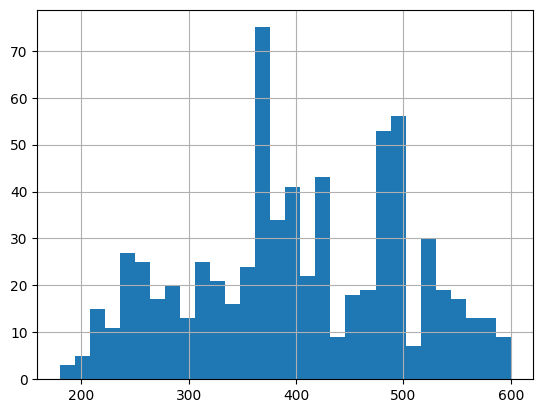

In [95]:
mLigh2['sleep_duration_min'].hist(bins=30)

### ✅ mScreenStatus 화면 사용여부

- Indicates whether the smartphone screen is in use.
 - 기상시간, 취침시간, 수면시간
 - 휴대폰 이용횟수, 이용시간
 - 00 - 05 사이에 휴대폰 이용한 건수
 - 결측치 처리 x

In [97]:
mScreenStatus['lifelog_date'] = mScreenStatus['timestamp'].astype(str).str[:10]
mScreenStatus.head(1)

,subject_id,timestamp,m_screen_use,lifelog_date
0,id01,2024-06-26 12:03:00,0,2024-06-26


In [121]:
def process_mScreenUse(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour

    # 1. 하루별 screen 사용 패턴 요약
    features = []

    for (subj, lifelog_date), group in df.groupby(['subject_id', 'lifelog_date']):
        status = group['m_screen_use'].values
        ratio_on = status.mean()
        transitions = (status[1:] != status[:-1]).sum()

        # 연속된 1(화면on) 상태 길이
        durations = []
        current = 0
        for val in status:
            if val == 1:
                current += 1
            elif current > 0:
                durations.append(current)
                current = 0
        if current > 0:
            durations.append(current)

        features.append({
            'subject_id': subj,
            'lifelog_date': lifelog_date,
            'screen_on_ratio': ratio_on,
            'screen_on_transitions': transitions,
            'screen_on_duration_avg': np.mean(durations) if durations else 0,
            'screen_on_duration_max': np.max(durations) if durations else 0,
        })

    daily_screen = pd.DataFrame(features)

    # 2. 수면 시간, 기상 시간 추정
    results = []

    for subject_id, group in tqdm(df.groupby('subject_id'), desc="Processing sleep detection (screen use)"):
        group = group.sort_values('timestamp').reset_index(drop=True)

        sleep_time = None
        wake_time = None
        sleeping = False
        zero_count = 0
        first_zero_time = None

        for i in range(len(group)):
            screen = group.loc[i, 'm_screen_use']
            hour = group.loc[i, 'hour']

            if screen == 0:
                zero_count += 1
                if zero_count == 1:
                    first_zero_time = group.loc[i, 'timestamp']
                if zero_count >= 120 and not sleeping:   # 2시간 연속
                    sleep_hour = first_zero_time.hour
                    if (sleep_hour >= 21) or (sleep_hour <= 2):
                        sleep_time = first_zero_time
                        sleeping = True
            else:
                if sleeping:
                    candidate_wakeup = group.loc[i, 'timestamp']
                    wake_hour = candidate_wakeup.hour
                    if 5 <= wake_hour <= 9:
                        wake_time = candidate_wakeup
                        results.append({
                            'subject_id': subject_id,
                            'lifelog_date': group.loc[i, 'lifelog_date'],
                            'sleep_time': sleep_time,
                            'wake_time': wake_time,
                            'sleep_duration_min': (wake_time - sleep_time).total_seconds() / 60
                        })
                        sleeping = False
                        zero_count = 0
                        first_zero_time = None
            if screen == 1:
                zero_count = 0
                first_zero_time = None

    sleep_df = pd.DataFrame(results)

    # 3. 수면시간 이상치 보정
    if not sleep_df.empty:
        mean_sleep = (
            sleep_df[(sleep_df['sleep_duration_min'] >= 180) & (sleep_df['sleep_duration_min'] <= 600)]
            .groupby('subject_id')['sleep_duration_min']
            .mean()
            .to_dict()
        )

        def replace_outlier(row):
            if (row['sleep_duration_min'] > 600) or (row['sleep_duration_min'] < 180):
                return mean_sleep.get(row['subject_id'], 360)
            else:
                return row['sleep_duration_min']

        sleep_df['sleep_duration_min'] = sleep_df.apply(replace_outlier, axis=1)

    # sleep_time, wake_time 숫자(hhmm) 변환
    def to_hhmm(t):
        if pd.isnull(t):
            return np.nan
        return t.hour * 100 + t.minute

    sleep_df['sleep_time_hhmm'] = sleep_df['sleep_time'].apply(to_hhmm)
    sleep_df['wake_time_hhmm'] = sleep_df['wake_time'].apply(to_hhmm)

    sleep_df = sleep_df.drop(columns=['sleep_time', 'wake_time'])

    ### lifelog_date 하루 전 빼기 -> 일어난날은 다음날이므로 -1 처리
    sleep_df['lifelog_date'] = sleep_df['lifelog_date'] + pd.Timedelta(days=-1)

    # 최종 merge
    final = pd.merge(daily_screen, sleep_df, on=['subject_id', 'lifelog_date'], how='left')

    return final

In [128]:
mScreenStatus_df2 = process_mScreenUse(mScreenStatus)

# check
print(f'\n # mScreenStatus_df2 shape: {mScreenStatus_df2.shape}')
mScreenStatus_df2.head()

Processing sleep detection (screen use): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


 # mScreenStatus_df2 shape: (700, 9)


,subject_id,lifelog_date,screen_on_ratio,screen_on_transitions,screen_on_duration_avg,screen_on_duration_max,sleep_duration_min,sleep_time_hhmm,wake_time_hhmm
0,id01,2024-06-26,0.2954,54,7.7778,60,349.0000,2327.0000,516.0000
1,id01,2024-06-27,0.3657,82,12.7561,79,371.0000,2308.0000,519.0000
2,id01,2024-06-28,0.3197,90,10.0889,51,416.0000,2300.0000,556.0000
3,id01,2024-06-29,0.2379,66,10.0909,82,488.0000,2148.0000,556.0000
4,id01,2024-06-30,0.2204,82,7.6341,69,390.0000,2242.0000,512.0000


### ✅ mUsageStats 앱사용통계
- mUsageStats: Indicates which apps were used on the smartphone and for how long.

 - 몇시까지 핸드폰 보다가 잠잤는지
 - 통화, 전화 얼마나 했는지
 - YouTube 얼마나 봤는지
 - 메시지, 카카오톡 얼마나 했는지
 - NAVER 얼마나 했는지
 - 평소보다 얼마나 많은 앱을 이용했는지
 - 제외? -> 시스템 UI,One UI 홈

In [135]:
def extract_mUsageStats_info(row):
    m_data = row['m_usage_stats']
    app_name = [item['app_name'] for item in m_data]
    total_time = [item['total_time'] for item in m_data]
    return pd.Series({'app_name': app_name, 'total_time': total_time})

mUsageStats[['app_name', 'total_time']] = mUsageStats.apply(extract_mUsageStats_info, axis=1)
mUsageStats['lifelog_date'] = mUsageStats['timestamp'].astype(str).str[:10]
mUsageStats.head(1)

,subject_id,timestamp,m_usage_stats,app_name,total_time,lifelog_date
0,id01,2024-06-26 13:00:00,"[{'app_name': ' 캐시워크', 'total_time': 69}, {'app_name': 'NAVER', 'total_time': 549}, {'app_name': ' ✝️성경일독Q', 'total_time': 7337}]","[ 캐시워크, NAVER, ✝️성경일독Q]","[69, 549, 7337]",2024-06-26


In [179]:
def process_mUsageStats(df):
    df = df.copy()
    df['lifelog_date'] = pd.to_datetime(df['lifelog_date'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['요일'] = df['lifelog_date'].dt.day_name()

    # 리스트 평탄화
    exploded_df = df.explode(['app_name', 'total_time'])
    exploded_df['total_time'] = exploded_df['total_time'].astype(float)
    exploded_df['total_time'] = exploded_df['total_time'] * 0.001 / 60  # 밀리초 → 초 → 분 변환

    # app_name 특수문자 제거
    exploded_df['app_name'] = exploded_df['app_name'].astype(str).apply(
        lambda x: re.sub(r'[^가-힣a-zA-Z0-9]', '', x)
    )

    # 시스템 앱 제거
    filtered_df = exploded_df[~exploded_df['app_name'].isin(['시스템UI'])]  # '시스템UI'만 제거 (OneUI홈은 포함)

    # 주요 파생변수 생성
    def calculate_daily_metrics(group):
        last_use = group['timestamp'].max()

        app_times = {
            '통화_시간(분)': group[group['app_name'] == '통화']['total_time'].sum(),
            '전화_시간(분)': group[group['app_name'] == '전화']['total_time'].sum(),
            'YouTube_시간(분)': group[group['app_name'] == 'YouTube']['total_time'].sum(),
            '메신저_시간(분)': group[group['app_name'].isin(['메시지', '카카오톡'])]['total_time'].sum(),
            'NAVER_시간(분)': group[group['app_name'] == 'NAVER']['total_time'].sum(),
            '캐시워크_시간(분)': group[group['app_name'] == '캐시워크']['total_time'].sum(),
            '성경일독Q_시간(분)': group[group['app_name'] == '성경일독Q']['total_time'].sum(),
            'OneUI홈_시간(분)': group[group['app_name'] == 'OneUI홈']['total_time'].sum(),
        }

        return pd.Series({
            **app_times,
            '고유앱수': group['app_name'].nunique(),
            '총화면시간(분)': group['total_time'].sum()
        })

    # daily metrics 생성
    daily_stats = filtered_df.groupby(['subject_id', 'lifelog_date']).apply(calculate_daily_metrics).reset_index()

    # subject_id별 평균 총화면시간 구하기
    avg_screen_time = daily_stats.groupby('subject_id')['총화면시간(분)'].mean().to_dict()

    # 평균대비 화면사용량(%) 생성
    def compute_screen_usage(row):
        avg_time = avg_screen_time.get(row['subject_id'], np.nan)
        if pd.isna(avg_time) or avg_time == 0:
            return np.nan
        return round((row['총화면시간(분)'] / avg_time - 1) * 100, 1)

    daily_stats['평균대비_화면사용량(%)'] = daily_stats.apply(compute_screen_usage, axis=1)

    return daily_stats

In [180]:
mUsageStats2 = process_mUsageStats(mUsageStats)

# check
print(f'\n # mUsageStats2 shape: {mUsageStats2.shape}')
mUsageStats2.head()


 # ch2025_mUsageStats2 shape: (689, 13)


,subject_id,lifelog_date,통화_시간(분),전화_시간(분),YouTube_시간(분),메신저_시간(분),NAVER_시간(분),캐시워크_시간(분),성경일독Q_시간(분),OneUI홈_시간(분),고유앱수,총화면시간(분),평균대비_화면사용량(%)
0,id01,2024-06-26,9.2089,12.0738,0.1061,58.2072,8.6203,24.1415,116.0727,89.1021,32.0000,423.6353,-43.6000
1,id01,2024-06-27,36.8588,16.7807,1.6092,105.8437,38.5881,49.3543,172.8651,241.0263,48.0000,901.7146,19.9000
2,id01,2024-06-28,25.8909,25.1555,23.9184,106.0977,37.1289,11.6179,184.0843,188.1730,38.0000,750.1050,-0.2000
3,id01,2024-06-29,7.5768,0.1234,28.4584,16.6718,29.2566,0.0547,134.8796,130.5228,45.0000,531.6114,-29.3000
4,id01,2024-06-30,43.7429,17.6889,15.8671,86.4018,16.9504,64.0179,209.7488,145.3321,47.0000,772.8496,2.8000


### ✅ mWifi 주변wifi 정보
- Wifi devices around individual subject.
 - -30 ~ -50 dBm	매우 강한 신호 (최적)
 - -51 ~ -60 dBm	강한 신호 (문제 없음)
 - -61 ~ -70 dBm	괜찮은 신호 (약간 느릴 수 있음)
 - -71 ~ -80 dBm	약한 신호 (끊김 주의)
 - -81 dBm 이하	매우 약한 신호 (거의 끊김)

In [187]:
def extract_wifi_info(row):
    wifi_data = row['m_wifi']
    bssids = [item['bssid'] for item in wifi_data]
    rssis = [item['rssi'] for item in wifi_data]
    return pd.Series({'bssid': bssids, 'rssi': rssis})

mWifi[['bssid', 'rssi']] = mWifi.apply(extract_wifi_info, axis=1)
mWifi['lifelog_date'] = mWifi['timestamp'].astype(str).str[:10]
mWifi.head(1)

,subject_id,timestamp,m_wifi,bssid,rssi,lifelog_date
0,id01,2024-06-26 12:03:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, {'bssid': 'a0:0f:37:9a:5d:8c', 'rssi': -78}, {'bssid': 'a0:0f:37:9a:5d:8d', 'rssi': -78}, {'bssid': 'a0:0f:37:9a:5d:8e', 'rssi': -78}, {'bssid': 'a0:0f:37:9a:5d:8f', 'rssi': -78}, {'bssid': 'a0:0f:37:96:56:ef', 'rssi': -58}, {'bssid': '88:36:6c:86:75:84', 'rssi': -72}, {'bssid': 'a0:0f:37:96:56:ee', 'rssi': -58}, {'bssid': 'a0:0f:37:96:56:ed', 'rssi': -58}, {'bssid': '86:25:19:b5:b2:a5', 'rssi': -61}, {'bssid': 'a0:0f:37:96:56:ec', 'rssi': -58}, {'bssid': '1e:39:29:8e:fb:e9', 'rssi': -71}, {'bssid': '52:c2:e8:c7:9b:e4', 'rssi': -82}, {'bssid': 'a0:0f:37:96:56:eb', 'rssi': -58}, {'bssid': '12:e3:c7:09:20:34', 'rssi': -88}, {'bssid': '58:86:94:4a:08:b8', 'rssi': -82}, {'bssid': '90:9f:33:28:d0:2e', 'rssi': -78}, {'bssid': '00:26:66:bc:4e:18', 'rssi': -85}, {'bssid': 'f6:0a:f4:43:4b:ba', 'rssi': -45}, {'bssid': '10:e3:c7:09:20:35', 'rssi': -63}, {'bssid': '10:e3:c7:09:20:34', 'rssi': -89}, {'bssid': '1c:39:29:48:04:92', 'rssi': -82}, {'bssid': '12:e3:c7:07:9d:df', 'rssi': -83}, {'bssid': '86:25:19:c3:44:07', 'rssi': -84}, {'bssid': 'a0:0f:37:9a:37:2f', 'rssi': -76}, {'bssid': 'a0:0f:37:9a:37:2e', 'rssi': -76}, {'bssid': 'a0:0f:37:9a:37:2d', 'rssi': -76}, {'bssid': '0a:09:b4:74:05:ec', 'rssi': -72}, {'bssid': 'a0:0f:37:9a:37:2c', 'rssi': -76}, {'bssid': 'a0:0f:37:9a:37:2b', 'rssi': -76}, {'bssid': '0a:09:b4:74:05:eb', 'rssi': -59}, {'bssid': 'c0:25:2f:d8:c1:a6', 'rssi': -82}, {'bssid': '16:7f:67:bb:fa:f8', 'rssi': -79}, {'bssid': '3c:f3:92:ff:00:01', 'rssi': -82}, {'bssid': '06:09:b4:74:05:ec', 'rssi': -72}, {'bssid': '06:09:b4:74:05:eb', 'rssi': -59}, {'bssid': '12:e3:c7:0a:74:d1', 'rssi': -78}, {'bssid': '88:36:6c:a9:6f:8e', 'rssi': -63}, {'bssid': '02:e3:c7:09:20:34', 'rssi': -88}, {'bssid': '00:09:b4:74:05:eb', 'rssi': -60}, {'bssid': '00:09:b4:74:05:ec', 'rssi': -72}, {'bssid': '00:1d:93:93:cf:fe', 'rssi': -19}, {'bssid': '8e:e2:ac:a5:9d:15', 'rssi': -72}]","[a0:0f:37:9a:5d:8b, a0:0f:37:9a:5d:8c, a0:0f:37:9a:5d:8d, a0:0f:37:9a:5d:8e, a0:0f:37:9a:5d:8f, a0:0f:37:96:56:ef, 88:36:6c:86:75:84, a0:0f:37:96:56:ee, a0:0f:37:96:56:ed, 86:25:19:b5:b2:a5, a0:0f:37:96:56:ec, 1e:39:29:8e:fb:e9, 52:c2:e8:c7:9b:e4, a0:0f:37:96:56:eb, 12:e3:c7:09:20:34, 58:86:94:4a:08:b8, 90:9f:33:28:d0:2e, 00:26:66:bc:4e:18, f6:0a:f4:43:4b:ba, 10:e3:c7:09:20:35, 10:e3:c7:09:20:34, 1c:39:29:48:04:92, 12:e3:c7:07:9d:df, 86:25:19:c3:44:07, a0:0f:37:9a:37:2f, a0:0f:37:9a:37:2e, a0:0f:37:9a:37:2d, 0a:09:b4:74:05:ec, a0:0f:37:9a:37:2c, a0:0f:37:9a:37:2b, 0a:09:b4:74:05:eb, c0:25:2f:d8:c1:a6, 16:7f:67:bb:fa:f8, 3c:f3:92:ff:00:01, 06:09:b4:74:05:ec, 06:09:b4:74:05:eb, 12:e3:c7:0a:74:d1, 88:36:6c:a9:6f:8e, 02:e3:c7:09:20:34, 00:09:b4:74:05:eb, 00:09:b4:74:05:ec, 00:1d:93:93:cf:fe, 8e:e2:ac:a5:9d:15]","[-78, -78, -78, -78, -78, -58, -72, -58, -58, -61, -58, -71, -82, -58, -88, -82, -78, -85, -45, -63, -89, -82, -83, -84, -76, -76, -76, -72, -76, -76, -59, -82, -79, -82, -72, -59, -78, -63, -88, -60, -72, -19, -72]",2024-06-26


In [197]:
def process_mWifi(df,threshold):

    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    def filter_strong_rssi(df,threshold):
        filtered_df = df.copy()
        def filter_row(row):
            bssids = row['bssid']
            rssis = row['rssi']
            # RSSI > threshold 조건 만족하는 항목만 추출
            filtered = [(b, r) for b, r in zip(bssids, rssis) if r > threshold]
            if filtered:
                new_bssids, new_rssis = zip(*filtered)
                return pd.Series({'bssid': list(new_bssids), 'rssi': list(new_rssis)})
            else:
                return pd.Series({'bssid': [], 'rssi': []})
        filtered_df[['bssid', 'rssi']] = filtered_df.apply(filter_row, axis=1)
        return filtered_df

    # === wifi 약신호 제거 ===
    df = filter_strong_rssi(df, threshold=threshold) ####

    features = []
    grouped = df.groupby(['subject_id', 'lifelog_date'])

    for (subject_id, date), group in grouped:
        scan_count = len(group)
        bssid_flat = sum(group['bssid'], [])  # flatten
        rssi_flat = sum(group['rssi'], [])    # flatten

        unique_bssid_count = len(set(bssid_flat))
        avg_rssi = sum(rssi_flat) / len(rssi_flat) if rssi_flat else None
        max_rssi = max(rssi_flat) if rssi_flat else None
        min_rssi = min(rssi_flat) if rssi_flat else None
        strong_rssi_ratio = sum(1 for r in rssi_flat if r > -60) / len(rssi_flat) if rssi_flat else 0
        empty_scan_count = sum(1 for b in group['bssid'] if len(b) == 0)

        # 가장 많이 탐지된 BSSID
        bssid_counter = Counter(bssid_flat)
        top_bssid, top_bssid_count = bssid_counter.most_common(1)[0] if bssid_counter else (None, 0)

        first_time = group['timestamp'].min()
        last_time = group['timestamp'].max()
        hour_span = (last_time - first_time).total_seconds() / 60  # 분 단위

        features.append({
            'subject_id': subject_id,
            'lifelog_date': date,
            'scan_count': scan_count,
            'unique_bssid_count': unique_bssid_count,
            'avg_rssi': avg_rssi,
            'max_rssi': max_rssi,
            # 'min_rssi': min_rssi,
            # 'strong_signal_ratio': strong_rssi_ratio,
            'empty_scan_count': empty_scan_count,
            'top_bssid': top_bssid,
            'top_bssid_count': top_bssid_count,
            'hour_span_minutes': hour_span
        })

    return pd.DataFrame(features)

In [198]:
mWifi2 = process_mWifi(mWifi,threshold=-60)

# check
print(f'\n # mWifi2 shape: {mWifi2.shape}')
mWifi2.head()


 # ch2025_mWifi2 shape: (685, 10)


,subject_id,lifelog_date,scan_count,unique_bssid_count,avg_rssi,max_rssi,empty_scan_count,top_bssid,top_bssid_count,hour_span_minutes
0,id01,2024-06-26,69,48,-49.6109,-19.0000,11,86:25:19:9f:9b:be,19,716.0000
1,id01,2024-06-27,126,21,-46.1197,-26.0000,25,04:09:a5:3a:c8:6a,52,1430.0000
2,id01,2024-06-28,118,27,-46.7500,-26.0000,18,04:09:a5:3a:c8:6b,47,1430.0000
3,id01,2024-06-29,134,18,-43.9807,-24.0000,11,04:09:a5:3a:c8:6b,117,1420.0000
4,id01,2024-06-30,108,25,-46.6265,-23.0000,7,04:09:a5:3a:c8:6b,69,1310.0000


### ✅ wHr 심박동수
- Heart rate readings recorded by the smartwatch.


In [202]:
wHr['lifelog_date'] = wHr['timestamp'].astype(str).str[:10]
wHr.head(1)

,subject_id,timestamp,heart_rate,lifelog_date
0,id01,2024-06-26 12:23:00,"[134, 134, 135, 133, 134, 135, 134, 135, 134, 133, 133, 133, 132, 132, 131, 131, 131, 132, 132, 134, 134, 134, 132, 130, 128, 126, 126, 126, 127, 129, 130, 129, 130, 130, 127, 127, 126, 125, 123]",2024-06-26


In [209]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wHr_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'lifelog_date']):
        block_stats = {'subject_id': subj, 'lifelog_date': date}

        for block, block_group in group.groupby('block'):
            hr_all = []
            for row in block_group['heart_rate']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row
                hr_all.extend([int(h) for h in parsed if h is not None])

            if not hr_all:
                continue

            above_100 = [hr for hr in hr_all if hr > 100]
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all)
            block_stats[f'hr_{block}_std'] = np.std(hr_all)
            block_stats[f'hr_{block}_max'] = np.max(hr_all)
            block_stats[f'hr_{block}_min'] = np.min(hr_all)
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all)

        results.append(block_stats)

    return pd.DataFrame(results)

In [210]:
wH2 = process_wHr_by_timeblock(wHr)

# check
print(f'\n # wH2 shape: {wH2.shape}')
wH2.head()


 # ch2025_wH2 shape: (636, 22)


,subject_id,lifelog_date,hr_afternoon_mean,hr_afternoon_std,hr_afternoon_max,hr_afternoon_min,hr_afternoon_above_100_ratio,hr_evening_mean,hr_evening_std,hr_evening_max,hr_evening_min,hr_evening_above_100_ratio,hr_early_morning_mean,hr_early_morning_std,hr_early_morning_max,hr_early_morning_min,hr_early_morning_above_100_ratio,hr_morning_mean,hr_morning_std,hr_morning_max,hr_morning_min,hr_morning_above_100_ratio
0,id01,2024-06-26,80.5333,12.6366,142.0000,59.0000,0.0773,82.4768,10.2932,124.0000,59.0000,0.0555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,87.4052,12.2970,125.0000,63.0000,0.1794,83.5265,10.9677,122.0000,61.0000,0.0829,86.1704,11.8754,113.0000,66.0000,0.1602,72.3440,10.3331,130.0000,53.0000,0.0234
2,id01,2024-06-28,83.0140,12.4885,135.0000,55.0000,0.0994,75.8213,9.1761,109.0000,59.0000,0.0187,90.8419,10.6966,123.0000,69.0000,0.2066,78.7753,12.4134,120.0000,51.0000,0.0728
3,id01,2024-06-29,53.0000,0.8165,54.0000,52.0000,0.0000,93.7273,7.4966,101.0000,78.0000,0.0909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,id01,2024-06-30,89.0687,9.1716,155.0000,61.0000,0.1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.7616,10.8382,132.0000,61.0000,0.1514


### ✅ wLight 앰비언트 라이트
- Ambient light measured by the smartwatch.  
  - 어두운 밤 0.1 ~ 1 lux 캄캄한 방, 달빛 없는 밤
  - 가로등 켜진 거리 10 ~ 20 lux 흐릿한 외부 조명
  - 실내 조명 100 ~ 500 lux 사무실, 일반 거실
  - 밝은 실외 10,000 ~ 25,000 lux 맑은 날 햇빛
  - 직사광선 아래 30,000 ~ 100,000 lux 여름 한낮, 매우 강한 햇빛

In [222]:
wLight['lifelog_date'] = wLight['timestamp'].astype(str).str[:10]
wLight.head(1)

,subject_id,timestamp,w_light,lifelog_date
0,id01,2024-06-26 12:17:00,633.0000,2024-06-26


In [223]:
def get_time_block(hour):
    if 0 <= hour < 6:
        return 'early_morning'
    elif 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

def process_wLight_by_timeblock(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date
    df['block'] = df['timestamp'].dt.hour.map(get_time_block)

    results = []

    for (subj, date), group in df.groupby(['subject_id', 'lifelog_date']):
        block_stats = {'subject_id': subj, 'lifelog_date': date}

        for block, block_group in group.groupby('block'):
            lux = block_group['w_light'].dropna().values
            if len(lux) == 0:
                continue

            block_stats[f'wlight_{block}_mean'] = np.mean(lux)
            block_stats[f'wlight_{block}_std'] = np.std(lux)
            block_stats[f'wlight_{block}_max'] = np.max(lux)
            block_stats[f'wlight_{block}_min'] = np.min(lux)

        results.append(block_stats)

    return pd.DataFrame(results)

In [224]:
wLight2 = process_wLight_by_timeblock(wLight)

# check
print(f'\n # wLight2 shape: {wLight2.shape}')
wLight2.head()


 # ch2025_wLight2 shape: (664, 18)


,subject_id,lifelog_date,wlight_afternoon_mean,wlight_afternoon_std,wlight_afternoon_max,wlight_afternoon_min,wlight_evening_mean,wlight_evening_std,wlight_evening_max,wlight_evening_min,wlight_early_morning_mean,wlight_early_morning_std,wlight_early_morning_max,wlight_early_morning_min,wlight_morning_mean,wlight_morning_std,wlight_morning_max,wlight_morning_min
0,id01,2024-06-26,394.5251,1458.7346,20874.0000,0.0000,89.0202,101.6844,264.0000,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,id01,2024-06-27,506.1220,1352.3586,8386.0000,0.0000,98.7171,137.9585,910.0000,0.0000,20.3306,63.7006,282.0000,0.0000,285.7642,1133.5771,12464.0000,0.0000
2,id01,2024-06-28,445.1088,1423.0945,14492.0000,0.0000,50.8522,112.5218,685.0000,0.0000,13.0588,50.3926,305.0000,0.0000,810.3333,5386.8360,91584.0000,0.0000
3,id01,2024-06-29,89.6738,123.5911,374.0000,0.0000,108.3833,142.7578,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,19.8015,12.9299,63.0000,0.0000
4,id01,2024-06-30,274.2929,653.3695,5425.0000,0.0000,24.0859,78.5251,322.0000,0.0000,0.0000,0.0000,0.0000,0.0000,111.1124,193.4138,979.0000,0.0000


### ✅ wPedo 걸음수
- Step data recorded by the smartwatch.

In [227]:
wPedo['lifelog_date'] = wPedo['timestamp'].astype(str).str[:10]
wPedo.head(1)

,subject_id,timestamp,step,step_frequency,running_step,walking_step,distance,speed,burned_calories,lifelog_date
0,id01,2024-06-26 12:09:00,10,0.1667,0,0,8.3300,0.1388,0.0000,2024-06-26


In [228]:
def process_wPedo(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['lifelog_date'] = df['timestamp'].dt.date

    summary = df.groupby(['subject_id', 'lifelog_date']).agg({
        'step': 'sum',
        'step_frequency': 'mean',
        'distance': 'sum',
        'speed': ['mean', 'max'],
        'burned_calories': 'sum'
    }).reset_index()

    # 컬럼 이름 정리
    summary.columns = ['subject_id', 'lifelog_date',
                       'step_sum', 'step_frequency_mean',
                       'distance_sum', 'speed_mean', 'speed_max',
                       'burned_calories_sum']

    return summary

In [229]:
wPed2 = process_wPedo(wPedo)

# check
print(f'\n # wPed2 shape: {wPed2.shape}')
wPed2.head()


 # ch2025_wPed2 shape: (653, 8)


,subject_id,lifelog_date,step_sum,step_frequency_mean,distance_sum,speed_mean,speed_max,burned_calories_sum
0,id01,2024-06-26,3578,0.0927,2782.1901,0.0721,1.5882,189.3191
1,id01,2024-06-27,3104,0.0385,2393.3726,0.0297,1.2907,288.9908
2,id01,2024-06-28,4153,0.0510,3219.4687,0.0395,1.6922,130.1095
3,id01,2024-06-29,0,0.0000,0.0000,0.0000,0.0000,0.0000
4,id01,2024-06-30,3003,0.0382,2330.9863,0.0297,1.4663,104.8097


### 📦 merge 데이터

In [ ]:
from functools import reduce

df_list = [
    mACStatus_df2,
    mActivity_df2,
    mAmbience_df2,
    mBle_df2,
    m_Gps_df2,
    mLight_df2,
    mScreenStatus_df2,
    mUsageStats_df2,
    mWifi_df2,
    wHr_df2,
    wHr_df2,
    wLight_df2,
    wPedo_df2
]

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list)

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3,scan_count,unique_bssid_count,avg_rssi,max_rssi,min_rssi,strong_signal_ratio,empty_scan_count,top_bssid,top_bssid_count,hour_span_minutes
0,id01,2024-06-27,2024-06-26,0,0,0,0,0,1,69.0000,393.0000,-70.1964,-19.0000,-91.0000,0.2309,0.0000,86:25:19:9f:9b:be,19.0000,716.0000
1,id01,2024-06-28,2024-06-27,0,0,0,0,1,1,126.0000,357.0000,-69.0629,-26.0000,-92.0000,0.2701,0.0000,04:09:a5:3a:c8:6a,54.0000,1430.0000
2,id01,2024-06-29,2024-06-28,1,0,0,1,1,1,118.0000,376.0000,-69.0941,-26.0000,-92.0000,0.2594,0.0000,04:09:a5:3a:c8:6a,47.0000,1430.0000
3,id01,2024-06-30,2024-06-29,1,0,1,2,0,0,134.0000,258.0000,-67.7897,-24.0000,-91.0000,0.3063,0.0000,04:09:a5:3a:c8:6a,117.0000,1420.0000
4,id01,2024-07-01,2024-06-30,0,1,1,1,1,1,108.0000,242.0000,-68.2999,-23.0000,-90.0000,0.2946,0.0000,04:09:a5:3a:c8:6a,70.0000,1310.0000


In [ ]:
# metrics_train의 lifelog_date → datetime.date 형으로 변환
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date

# merged_df의 date도 변환
merged_df['lifelog_date'] = pd.to_datetime(merged_df['lifelog_date']).dt.date

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'lifelog_date'], how='inner')

# 3. test_df: metrics_train에 없는 (subject_id, date)
merged_keys = merged_df[['subject_id', 'lifelog_date']]
train_keys = metrics_train_renamed[['subject_id', 'lifelog_date']]
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'lifelog_date'], how='left', indicator=True)
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge'])

test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'lifelog_date'], how='left')

,subject_id,sleep_date,lifelog_date,Q1,Q2,Q3,S1,S2,S3,scan_count,unique_bssid_count,avg_rssi,max_rssi,min_rssi,strong_signal_ratio,empty_scan_count,top_bssid,top_bssid_count,hour_span_minutes
0,id01,2024-07-31,2024-07-30,0,0,0,0,0,0,115.0000,910.0000,-73.8566,-29.0000,-93.0000,0.1451,0.0000,86:25:19:9f:9b:be,42.0000,1400.0000
1,id01,2024-08-01,2024-07-31,0,0,0,0,0,0,135.0000,492.0000,-69.2624,-33.0000,-93.0000,0.2579,0.0000,04:09:a5:3a:c8:6a,48.0000,1430.0000
2,id01,2024-08-02,2024-08-01,0,0,0,0,0,0,124.0000,397.0000,-72.1787,-33.0000,-92.0000,0.2053,0.0000,86:25:19:9f:9b:be,49.0000,1428.0000
3,id01,2024-08-03,2024-08-02,0,0,0,0,0,0,132.0000,366.0000,-69.7404,-27.0000,-93.0000,0.2188,0.0000,04:09:a5:3a:c8:6a,53.0000,1430.0000
4,id01,2024-08-04,2024-08-03,0,0,0,0,0,0,107.0000,312.0000,-69.6403,-21.0000,-93.0000,0.2214,0.0000,04:09:a5:3a:c8:6a,77.0000,1420.0000
